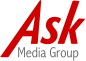
<img src="https://static1.squarespace.com/static/58dc1a1ee4fcb51cbb80a096/t/58ebf4a0f7e0abb89e582c80/1521491055921/?format=1500w">

![No Guns](images/no-guns.png)

<!-- Move the Accel AI logo to the right of the Ask logo, place the no guns image in the middle -->

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

# Taboo Igloo Challenge

> As a website owner, you need to identify user queries about weapons so that you can protect your brand identity.

In today's session we will:

- Add textual features to real queries
- Re-sample data as we have imbalanced classes
- Train classification models
- Compare and contrast model results

**Disclaimer:** We are working with raw user text. We have attempted to remove offensive queries. However, we cannot guarentee that the data are free of offensive material.

## Installation

Before we get started, we will need to install the notebook and third-party packages. There a few options for doing this.

**Note:** We will need to load a word embedding model into spaCy. Since these are large files, spaCy distributes them separately from the core package. This file is in the dcoker image.

### Docker

[Docker images](https://docs.docker.com/) have the advantage of grouping the data and _all_ the underlying environment together. 

```sh
docker run -p 8888:8888 andrewjstryker/taboo
```

### Conda virtual

[Anaconda](https://www.anaconda.com/) provides a data science wrapper on top of Python (and other languages).

```sh
# get the code from GitHub
git clone https://github.com/AskMediaGroup/TabooIglooChallenge.git
cd tabooigloochallege

# create and start a virtual environment
conda create --name taboo python=3.6
conda install --name taboo pip
source activate taboo
pip install -r requirements.txt
python -m spacy download en_core_web_lg

# start the notebook
jupyter notebook taboo-igloo-challenge.ipynb
```

### Python virtual environment

We will also want to run this code inside a Python [virtual environment](https://docs.python.org/3/library/venv.html). Virtual environments mitigate the problems of managing system-wide packages.

```sh
# get the code from GitHub
git clone https://github.com/AskMediaGroup/TabooIglooChallenge.git
cd tabooigloochallege

# create and start a virtual environment
python3 -m venv env
source env/bin/activate

# install the packages we need
pip install -r requirements.txt
python -m spacy download en_core_web_lg

# start the notebook
jupyter notebook taboo-igloo-challenge.ipynb
```

## Configuration

We will use a several third-party Python packages in our analysis:

- [**numpy**](https:http://www.numpy.org/): large array
- [**pandas**](https://pandas.pydata.org/): data structures

- [**scikit-learn**](http://scikit-learn.org/stable/index.html): data mining and analysis
- [**imbalanced-learn**](http://contrib.scikit-learn.org/imbalanced-learn/stable/): support for working with imbalanced classes
- [**spaCy**](https://spacy.io/): natural language processing

- [**matplotlib**](https://matplotlib.org/): plotting library

In [3]:
from itertools import islice

import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.decomposition import PCA
import imblearn
import spacy

import matplotlib.pyplot as plt

Let's also get extra space for making inline plots -- this lets us place plots side by side.

In [4]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10,6)

Populating the interactive namespace from numpy and matplotlib


## Load

Our data in the [JSON lines](http://jsonlines.org/) format. This format allows us to avoid some of the limitation of  comma separated value (CSV) files.

```json
[" Patty Hearst photos", false]
["AK-47", true]
["parsley, sage, rosemary, thyme", false]
```

We will use the Pandas [`read_json`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_json.html) method to read the file into a DataFrame. The argument `lines=True` instructs the parser to treat each line as a JSON object.

In [5]:
weapons = (pd.read_json("weapons-sample.jsonl", lines=True) 
             .rename(columns={0: "query", 1: "weapon"}))
weapons.head(20)

,query,weapon
0,polynesian totum poles,False
1,victorscott.co.uk,False
2,triumph bobber price,False
3,3921 N. R St Pensacola Fla,False
4,used truks in okc,False
5,clinical psycology,False
6,where is pavillion ohio shopping center,False
7,"""Add your comment"" ""Coppermine Photo Gallery"" ...",False
8,hotels for sale hot springs ar,False
9,2017 beretta 92a1 youtube,False


Let's see how many observations we have in each class:

In [6]:
weapons.weapon.value_counts()

False    1079777
True        4759
Name: weapon, dtype: int64

This confirms our suspicion that we have an imblanced class problem.

## Transform

We will transform the data in the following ways:

1. Reduce the problem size through re-sampling. We have over a million records since there are relatively few cases of the minority class. We will re-sample the data to reduce the problem size and balance the classes.

2. Create textual features for each query. We will use a [word2vec](https://en.wikipedia.org/wiki/Word2vec) approach to create a [distributed representation](https://en.wikipedia.org/wiki/Artificial_neural_network#distributed_representation) for the queries. This transformation creates the features that we will use to predict whether a query is about weapons.

3. Split the data into train and test sets so that we can use cross-validation to check our predictions.

4. Re-sample to balance the classes. Classifiers typically do work not well with severely imbalanced classes, such as our data.

### Reduce the problem size

Our first challenge is that computations on data of this size will take a long time. There are two feasible techniques to move forward:

1. Move to a big data processing platform such as [Apache Spark](https://spark.apache.org).
2. Down-sample the majority class.

We will move forward with option 2 in this notebook and save the big processing solution for another time. Let's keep all the queries where `weapons` are `True` and take a 5% sample where `weapons` are `True`.

In [7]:
ran = np.random.rand(len(weapons))
weapons_sample = pd.concat((weapons[weapons.weapon],
                            weapons[(weapons.weapon == False) & (np.random.rand(len(weapons)) < 0.05)]))
print(weapons.weapon.value_counts())
pd.concat((weapons_sample.head(), weapons_sample.tail()))

False    1079777
True        4759
Name: weapon, dtype: int64


,query,weapon
76,Essay on Teachers Should NOT Carry Guns,True
1098,San Leandro bebe gun shooter CA,True
1156,ar15 in 6.8mm,True
1658,World Of Tanks YouTube,True
1680,gun charge snetencing,True
1084485,swansons vitamins foloc acid,False
1084502,michelle regan thornton co,False
1084504,mechanism of insulin resistance in acromegaly,False
1084530,stanch in the artheri,False
1084531,railroad car wheel bearings,False


In [8]:
weapons_sample.weapon.value_counts()

False    53926
True      4759
Name: weapon, dtype: int64

### Generate textual features

The idea of [word2vec](https://en.wikipedia.org/wiki/Word2vec) is that we can project words into a vector space. Word vectors with similar context and meaning are in close proximity. This transformation results in a vector for each query. We will use these vectors as the features in our model.

#### Create the pipeline

[Natural-language processing](https://en.wikipedia.org/wiki/Natural-language_processing) packages, such as [spaCy](https://spacy.io), begin with building a pipeline. The pipeline contains the algorithms and data that we will apply to our text. The function `spacy.load()` builds an NLP pipeline from a model file. The [`en_core_web_lg`](https://spacy.io/models/en#en_core_web_lg) model file contains data from a web crawl of news, blogs, and comments.

In [9]:
nlp = spacy.load("en_core_web_lg")

#### Build the feature matrix

The Scikit-learn classifying models takes Numpy arrays as its inputs. Thus, we need an array with one row for each query and one column for each word vector element. We also need to convert the dependent variable in to array. The call to [`nlp.pipe`](https://spacy.io/api/pipe#pipe) allows spaCy to run through all of our queries in parallel.

In [10]:
X = np.zeros((len(weapons_sample), nlp.vocab.vectors_length), dtype=np.float32)
y = np.array(weapons_sample['weapon'])

print(X.shape)

# parse all the all the queries in parallel
for (i, doc) in enumerate(nlp.pipe((str(x) for x in weapons_sample['query']))):
    # store each word vector as a row
    X[i,] = doc.vector

(58685, 300)


#### Visualize the results

Let's take a look at this data so that we understand what we have. We will use [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) to reduce our vector space to two dimensions that we can graph.

In [11]:
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X)

Next, we define a helper function to capture the plotting logic. We will make several variations of the PCA scatter plot.

In [12]:
def splot(ax, X, y, title, labels=['Weapon', 'Clean'], alpha=0.3, samples=None,
          xlim=[-5, 5], ylim=[-5, 5]):
    if samples is not None and samples < len(X):
        indx = np.random.choice(len(X), samples)
        X = X[indx,]
        y = y[indx]
         
    c_weapon = ax.scatter(X[y, 0], X[y, 1], label=labels[0], alpha=alpha)
    c_clean = ax.scatter(X[y==False, 0], X[y==False, 1], label=labels[1], alpha=alpha)
    ax.set_title(title)
    
    # make the plot look pretty
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_autoscaley_on(False)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return (c_weapon, c_clean)

Now, we are ready to plot the results.

(<matplotlib.collections.PathCollection at 0x7ff451419e48>,
 <matplotlib.collections.PathCollection at 0x7ff45120c1d0>)

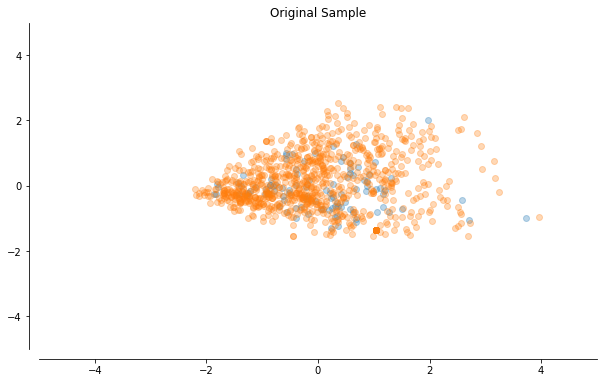

In [13]:
f, ax = plt.subplots(1, 1)
splot(ax, X_vis, y, "Original Sample", samples=1000)

### Create training and testing sets

We now group the data into a test and training sets. We split the data evenly since each set is equally import and we have enough observations.

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

We will use the training set for the rest of the model development. We use the testing set once we are ready to validate our results.

### Re-sample

We want to resample our data so that we improve the balance between the minority and majority classes. One of the simpliest methods is to use a [naive random over-sampling](http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html#random-over-sampler) technique.

In [15]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

We now have an equal number of observations in each class.

In [16]:
np.unique(y_ros, return_counts=True)

(array([False,  True]), array([26973, 26973]))

Let's visualize the results using PCA technique described above.

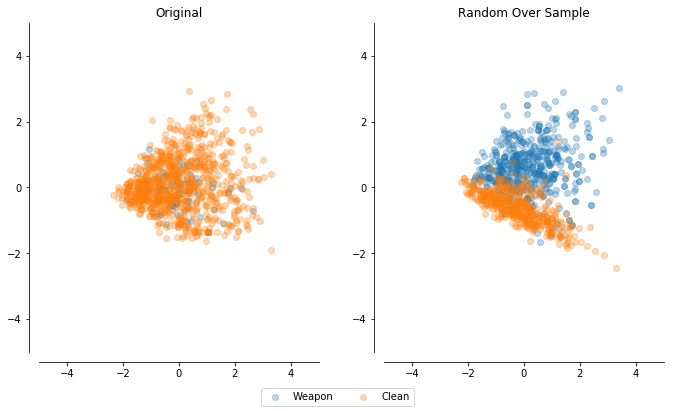

In [17]:
# PCA
X_ros_vis = pca.fit_transform(X_ros)

f, (ax1, ax2) = plt.subplots(1, 2)
cs = splot(ax1, X_vis, y, "Original", samples=1000)
splot(ax2, X_ros_vis, y_ros, "Random Over Sample", samples=1000)

plt.figlegend(cs, ('Weapon', 'Clean'), loc='lower center',
              ncol=2, labelspacing=0.)
plt.tight_layout(pad=3)

Note: we shouldn't expect the same shape in both plots as we applied PCA to different matrices.

Now your turn. Repeat this example with re-sampling strategy. Be sure to plot the results, following the example above.

### SMOTE

[SMOTE](https://link.springer.com/content/pdf/10.1007%2F978-3-540-39804-2_12.pdf) is a technique for synthezing minority class obersvations. The algorithms uses [k-nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) to new observations in the neighborhood of mintority class observations.

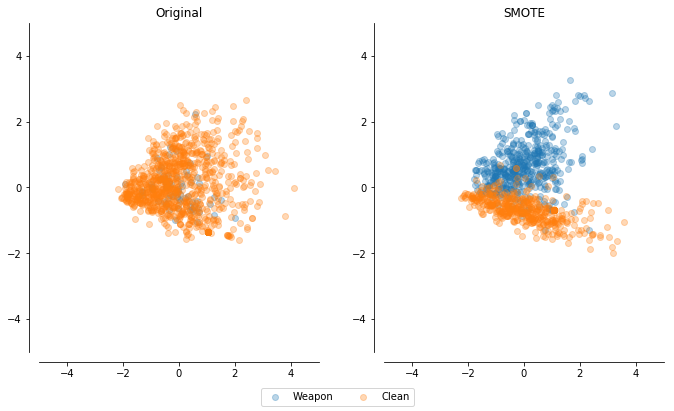

In [18]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote, y_smote = smote.fit_sample(X_train, y_train)

X_smote_vis = pca.fit_transform(X_smote)

f, (ax1, ax2) = plt.subplots(1, 2)
cs = splot(ax1, X_vis, y, "Original", samples=1000)
splot(ax2, X_smote_vis, y_smote, "SMOTE", samples=1000)

plt.figlegend(cs, ('Weapon', 'Clean'), loc='lower center',
              ncol=2, labelspacing=0.)
plt.tight_layout(pad=3)

### ADASYN

[Adaptive Synthetic Sampling Approach (ADASYN)](http://www.ele.uri.edu/faculty/he/PDFfiles/adasyn.pdf), like SMOTE, ADASYN sythesizes minority class observations. The major difference is that ADASYN synthesizes difficult to learn observations. That is, minority class observations near observations in the majority class.

Use the [ADASYN](http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.over_sampling.ADASYN.html) class in imbalanced-learn to re-sample the data.

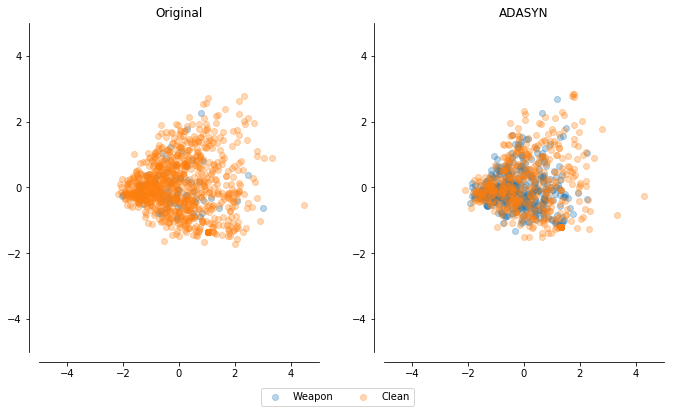

In [34]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_sample(X_train, y_train)

X_adasyn_vis = pca.fit_transform(X_adasyn)

f, (ax1, ax2) = plt.subplots(1, 2)
cs = splot(ax1, X_vis, y, "Original", samples=1000)
splot(ax2, X_adasyn_vis, y_adasyn, "ADASYN", samples=1000)

plt.figlegend(cs, ('Weapon', 'Clean'), loc='lower center',
              ncol=2, labelspacing=0.)
plt.tight_layout(pad=3)

### Reflect

Before moving forward, reflect on the results:

1. What are the strengths and weaknesses of each approach?

2. Which method will you use?

3. List at least two reasons for being optimistic about estimating a model with these data.

4. List at least two reasons for being pesimistic.

Now, set `X_resampled` and `y_resampled` to the matrices that you want to use.

In [20]:
X_resampled, y_resampled = X_adasyn, y_adasyn

## Train classifiers

Our goal is a classification model that takes a user query and returns the probablity that the query refers to a weapon. We will use a [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) as a benchmark. Logistic models two important properties for our application. Logistic models:

- Treat the dependent variable (the query is about weapons) is a linear combination of all the features.
- Require less computation than other common classification algorithms.

These properties make logistic classifiers a suitable as a good benchmark when doing classification modeling. Scikit-learn defines a [`LogisticRegression`](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) for this model.

In [21]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
%time logit.fit(X_resampled, y_resampled)
predicted_insample = logit.predict(X_train)
print(sk.metrics.classification_report(y_train, predicted_insample))

CPU times: user 4.72 s, sys: 88 ms, total: 4.81 s
Wall time: 4.81 s
             precision    recall  f1-score   support

      False       0.99      0.94      0.97     26973
       True       0.58      0.94      0.72      2369

avg / total       0.96      0.94      0.95     29342



We commonly measure the [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) of a classifier to  assess performance.

Let's use:

- **T** for predictions that match observed data 
- **F** for predictions that do *not* match observed data
- **P** for positive predictions (weapons)
- **N** for negative predictions (no weapons)

Precision is $\frac{TP}{TP + FP}$.

Recall is $\frac{TP}{TP + FN}$.

In [22]:
%time predicted = logit.predict(X_test)
print(sk.metrics.classification_report(y_test, predicted))

CPU times: user 40 ms, sys: 104 ms, total: 144 ms
Wall time: 57.5 ms
             precision    recall  f1-score   support

      False       0.99      0.94      0.96     26953
       True       0.56      0.92      0.70      2390

avg / total       0.96      0.93      0.94     29343



Now your turn. Try fitting the data to each of the following models.

### Decision Tree

[Decision tree](https://en.wikipedia.org/wiki/Decision_tree) models that takes it name and form from [tree](https://en.wikipedia.org/wiki/Tree_%28data_structure%29). Each of the interior nodes represent a model feature. The exterior nodes represent the classification. This illustration, from Wikipdia, shows a descision tree trained on the Titantic survial data.

![decision tree illustration from wikipedia](https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png)

Use the [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/tree.html#classification) class in Scikit-learn to train the decision tree model.

In [23]:
from sklearn import tree
t = tree.DecisionTreeClassifier()
%time t.fit(X_resampled, y_resampled)
predicted_insample = t.predict(X_train)
print(sk.metrics.classification_report(y_train, predicted_insample))

CPU times: user 45.5 s, sys: 44 ms, total: 45.6 s
Wall time: 45.5 s
             precision    recall  f1-score   support

      False       1.00      1.00      1.00     26973
       True       1.00      0.99      0.99      2369

avg / total       1.00      1.00      1.00     29342



In [24]:
%time predicted = t.predict(X_test)
print(sk.metrics.classification_report(y_test, predicted))

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 12.7 ms
             precision    recall  f1-score   support

      False       0.97      0.92      0.95     26953
       True       0.44      0.67      0.53      2390

avg / total       0.93      0.90      0.91     29343



### Random Forest

The [random forest model](https://en.wikipedia.org/wiki/Random_forest) is an *ensemble* model. Ensemble models are composed of two or more models. Random forests are composed of mutliple decision trees. Random forests have the advantage of avoiding some of the [overfitting](https://en.wikipedia.org/wiki/Overfitting) issues that are common in decision tree models.

Use the [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class in Scikit-learn to train the random forest model.

In [25]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
%time rfc.fit(X_resampled, y_resampled)
predicted_insample = rfc.predict(X_train)
print(sk.metrics.classification_report(y_train, predicted_insample))

CPU times: user 11.5 s, sys: 0 ns, total: 11.5 s
Wall time: 11.5 s
             precision    recall  f1-score   support

      False       1.00      1.00      1.00     26973
       True       1.00      0.99      0.99      2369

avg / total       1.00      1.00      1.00     29342



## Apply the model

Let's see well your favorite model on a set *loaded* keywords.

Reset the variable `model` to point to your preferred model

In [26]:
model = t

Let's load a file of suspect text.

In [27]:
with open("test-words.txt") as f:
    suspect = [x.strip() for x in f] # .strip() removes the new line character
    
suspect[:20]

['sex pistols',
 "janie's got a gun",
 'my little pony',
 'Sheriff Woody',
 'stick-em up',
 'water pistol',
 'magnum ice cream',
 'Agram 2000',
 'American-180',
 '.22 Short Magnum',
 'AR-57',
 'Armaguerra OG-43',
 'Arsenal submachine gun',
 'ASALT 96',
 'Austen submachine gun',
 'W. T. Carmichael',
 'Bechowiec-1',
 'Beretta 93R',
 'Beretta PMX[1]',
 'Beretta Mx4 Storm']

### Create the word vectors

In [28]:
vectorized = np.vstack(x.vector for x in nlp.pipe(suspect))
vectorized[:10, :4]

array([[-0.241595  , -0.062707  , -0.34531   , -0.0474    ],
       [ 0.044776  ,  0.24636781, -0.01670596,  0.132314  ],
       [-0.23827334,  0.16899668, -0.32244667,  0.13737667],
       [-0.29907   ,  0.325125  , -0.325612  , -0.35764   ],
       [-0.03612525, -0.05963249, -0.35501748,  0.070346  ],
       [-0.0245855 ,  0.020595  ,  0.08190501, -0.31641   ],
       [ 0.16107334, -0.16840632,  0.21563633, -0.38236666],
       [-0.030968  ,  0.016915  ,  0.082975  , -0.183975  ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.14922565,  0.10136033, -0.2683867 , -0.23296332]],
      dtype=float32)

Apply the model to the word vector matrix.

In [29]:
%time probs = model.predict_proba(vectorized)

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 337 µs


In [30]:
results_df = pd.DataFrame({"query": suspect, "prediction": probs[:,1]})
results_df

,query,prediction
0,sex pistols,0.000000
1,janie's got a gun,1.000000
2,my little pony,0.000000
3,Sheriff Woody,0.000000
4,stick-em up,0.000000
5,water pistol,1.000000
6,magnum ice cream,0.000000
7,Agram 2000,0.000000
8,American-180,0.259551
9,.22 Short Magnum,1.000000


## Reflect

Answer the following questions about your models:

1. As a website owner, would you be comfortable with any of these models? Which model would you select?

2. Describe how model you chose works.

3. How much time does the model need to process one query?

4. What are the strengths and limitations of your chose model compared to the logitic regression model? If you prefer the logistic regression model, what are its strengths and limitations compared to the next best alternative?

5. What steps would you take to improve the model?

# Review

- What textual features did we add?

- List three re-sampling techniques for imbalanced classes

- What method do we call to train a classification model? What is the input?

- What is one advantage of a logitistic model? What is one disadvantage?
